### Conditional Heteroskedasticity

금융시장의 이분산성에 대해 이해하고 고급 시계열 변동성 분석 방법에 대해 배우도록 한다

#### 1. Stationaity and Heteroskedasticity

**1.1 Stationarity**

AR process의 기본 가정은 다음과 같다

- strict stationarity
    - 임의의 자연수 $t_1, t_2, \cdots, t_n$과 자연수 k에 대하여 n개의 확률변수에 대한 결합확률밀도함수와, 이 n개의 확률변수에서 k만큼의 시간 축을 이동하였을 때의 결합확률밀도함수가 동일하다면, 이 시계열은 강정상성(Strict Stationarity)를 갖는다
    - 따라서 어떤 확률과정이 강정상성 조건을 만족한다면 모든 n에 대하여 결합확률밀도함수가 시간대를 바꾸어도 동일하다는 것을 보여야 하므로, 어떠한 시간대이든 분포가 항상 동일해야 한다

- weak stationarity
    - 확률과정이 유한한 2차 적률(**Finite Second Moment**)을 갖고, 기댓값과 분산이 시점 t와 무관하게 항상 일정하며 자기공분산이 시점 t가 아닌 시차 k에 의존한다면 이를 약한 의미의 정상성을 갖는다
    - $\mathrm{E}(Z_t) = \mu,~~ \mu \in \mathbf{R}$
    - $\mathrm{Var}(Z_t) = \sigma ^ 2, ~~ \sigma ^ 2 \in \mathbf{R}$
    - $\mathrm{Cov}(Z_t, Z_{t+k}) = \sigma_K, ~~\mathrm{for~any~t,h \geq 1}$

즉 금융 데이터(여기서 보통 1차 차분한 데이터를 의미한다)가 weak stationary 하다면, 그 데이터를 제곱한 수와 절대값을 취한 수 또한 weak stationary의 가정을 만족해야 한다. 그러나, 실제로 데이터에 변형을 취하면 자산가격은 weak stationarity를 보이지 않는다

In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

kosdaq = pdr.DataReader("KOSDAQ", "naver", start_date, end_date).astype(float)
kosdaq

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,672.53,674.30,666.62,674.02,783730.0
2020-01-03,677.57,679.37,668.10,669.93,903858.0
2020-01-06,660.08,663.10,653.61,655.31,884278.0
2020-01-07,660.87,664.21,659.18,663.44,970306.0
2020-01-08,657.24,658.14,637.43,640.94,1379708.0
...,...,...,...,...,...
2022-12-23,704.93,704.93,691.25,691.25,1107302.0
2022-12-26,691.94,696.96,686.80,694.68,797707.0
2022-12-27,697.25,704.21,697.25,704.19,901437.0


In [2]:
ret = np.log(kosdaq.Close / kosdaq.Close.shift(1)).dropna()
ret

Date
2020-01-03   -0.006087
2020-01-06   -0.022065
2020-01-07    0.012330
2020-01-08   -0.034503
2020-01-09    0.038489
                ...   
2022-12-23   -0.033809
2022-12-26    0.004950
2022-12-27    0.013597
2022-12-28   -0.016928
2022-12-29   -0.019072
Name: Close, Length: 741, dtype: float64

weak stationary 가정을 만족하는지 보여주기 위해서 다음과 같은 자산 가격 시계열을 새롭게 생성한다

In [3]:
ret_square = ret ** 2
ret_abs = np.abs(ret)

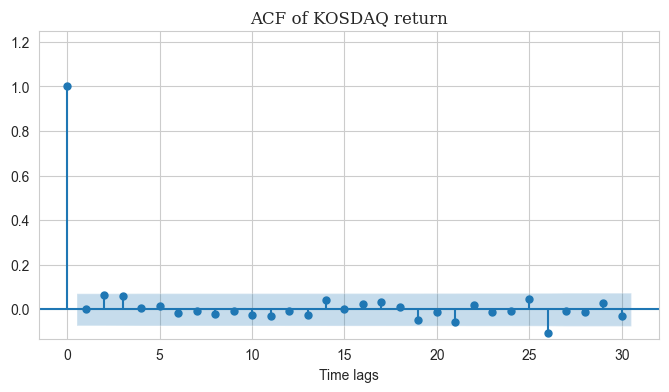

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(ret, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of KOSDAQ return', fontsize = 12, fontfamily = 'Serif')
plt.show()

1차 차분한 수익률 벡터에 대해서는 위와 같이 안정성을 띄는 것을 볼 수 있다

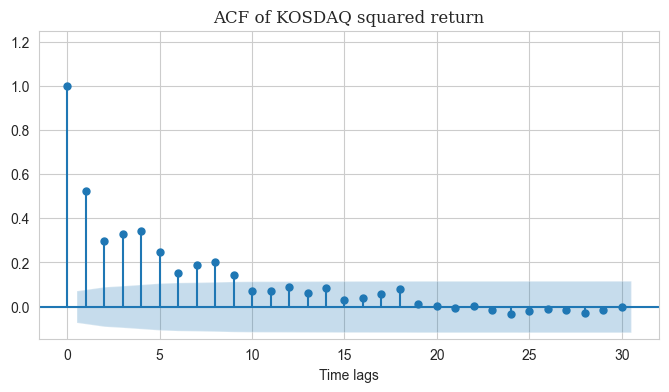

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(ret_square, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of KOSDAQ squared return', fontsize = 12, fontfamily = 'Serif')
plt.show()

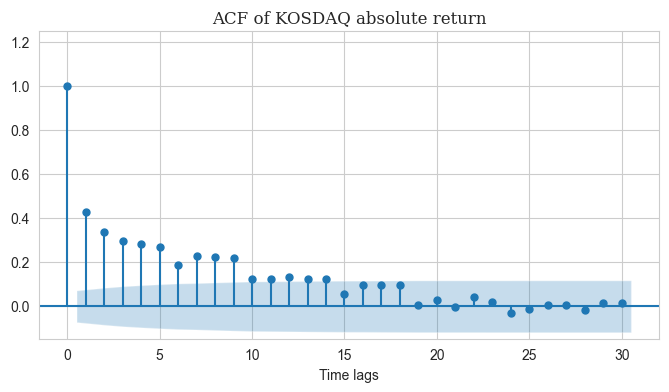

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(ret_abs, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF of KOSDAQ absolute return', fontsize = 12, fontfamily = 'Serif')
plt.show()

그러나, 각각 수익률의 제곱과 절대값은 안정적이지 않다. 따라서, 대부분의 금융 시계열 데이터는 IID 가정을 만족시키지 못한다는 것을 알 수 있다.

이것이 우리가 금융 시계열 데이터에서 이분산성을 고려해야 하는 이유이다

**1.2 Characteristics of Volatility**

주식 변동성의 특별한 특징은 직접 관측할 수 없다는 것이다. 그러나 변동성은 직접적으로 관찰할 수는 없지만 자산 수익률에서 흔히 볼 수 있는 몇 가지 특징을 가지고 있다.

1. 변동성 군집이 존재한다. 즉, 특정 기간에는 변동성이 높고 다른 기간에는 낮을 수 있다
2. 변동성은 시간이 지남에 따라 지속적인 방식으로 진화한다. 즉, 변동성의 널뛰기 현상은 드물다
3. 변동성이 무한대로 발산되지 않는다. 즉, 변동성은 일정한 범위 내에서 변동성이 변한다는 것이다. 통계적으로 말하면 변동성은 종종 정지해 있다는 것을 의미한다
4. 넷째, 변동성은 레버리지 효과로 일컬어지는 큰 가격 상승이나 큰 가격 하락에 다르게 반응하는 것으로 보인다. 이러한 속성들은 변동성 모형의 발전에 중요한 역할을 한다

일부 변동성 모형은 앞서 언급한 특징을 포착하지 못해 기존 모형의 약점을 보완하기 위해 구체적으로 제안되었다. 예를 들어, EGARCH 모형은 큰 긍정적인 자산 수익률과 부정적인 자산 수익률이 유발하는 변동성의 비대칭성을 포착하기 위해 개발되었다

Text(0.5, 1.0, 'Characteristis of volatility')

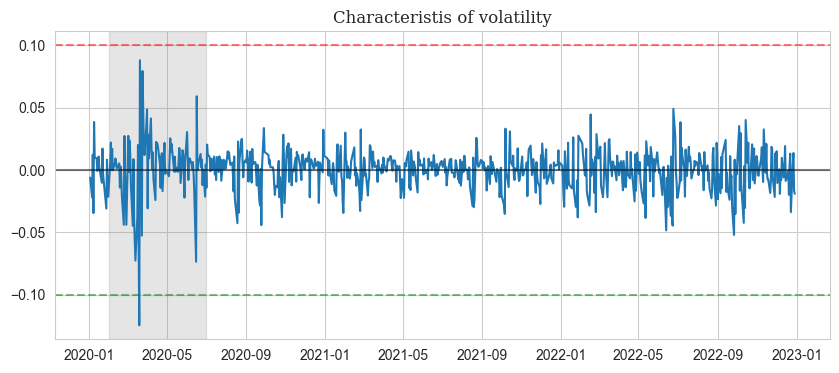

In [7]:
plt.figure(figsize = (10,4))
plt.plot(ret)
plt.axvspan('2020-02-01', '2020-06-30', color = 'gray', alpha = 0.2)
plt.axhline(0, color = 'black', alpha = 0.5)
plt.axhline(0.1, color = 'red', linestyle = '--', alpha = 0.5)
plt.axhline(-0.1, color = 'green', linestyle = '--', alpha = 0.5)
plt.title('Characteristis of volatility', fontfamily = 'Serif')

위 그래프와 같이 변동성이 심한 구간에서는 한동안 변동이 심해지는 **변동성 군집(Volatility clustering)** 현상을 확인할 수 있으며, 발산하지 않고 비교적 안정적인 범위 내에서 진동하는 모습을 포착할 수 있다.

#### 2. Model Building

변동성 모형을 적절한 관점에서 설명하기 위해서는 $F_{t-1}$이 주어진 $r_t$의 조건부 평균과 분산을 고려하는 것이 유익하다

$$μ_t = E(r_t|F_{t−1}), σ_t^2 = \mathrm{Var}(r_t|F_{t−1})=E[(r_t −μ_t)^2|F_{t−1}]$$

여기서 $F_{t-1}$이란 $t-1$시기에 가용가능한 모든 정보의 집합이다. 여기서 얻을 수 있는 정보에는 정보의 비대칭성이나 비효율적 시장이 아니다.
$\mathrm{ARCH}$ 모형 추정을 위해 $r_t$가 일부 설명 변수가 있는 안정적인 $\mathrm{ARMA}(p,q)$모형과 같은 간단한 시계열 모형을 따른다고 가정한다

$$r_t = μ_t + a_t, ~~~~~ μ_t = \sum_{i=1}^p \phi_i y_{t-i} + a_t - \sum_{i=1}^q \theta_i a_{t-i}, ~~~~~ y_t = r_t - \phi_0 - \sum_{i=1}^k β_i x_{it}$$

여기서 $y_t$는 단순히 설명 변수의 효과를 제거한 후의 조정된 임의의 time series를 나타낸다. 위 두개의 식에 의해

$$\sigma_t^2 = \mathrm{Var}(r_t|F_{t-1}) = \mathrm{Var}(a_t |F_{t-1})$$

임을 보일 수 있다

조건부 이분산 모형은 크게 두 가지로 나눌 수 있는데, $\sigma_t^2$의 변동을 함수로 표현하는 방식과 $\sigma_t^2$의 변동을 확률방정식으로 해석하는 것으로 나뉜다. $\mathrm{ARCH}$모형은 전자에 속하고, $\mathrm{SV model}$은 후자에 속한다

**2.1 test ARCH effect**

Volatility model을 제작하기 위해서는 다음과 같은 과정이 필요하다

1. 데이터의 Serieal Dependence를 테스트하고 필요한 경우 Linear dependence를 제거하기 위해 return series에 대한 계량 모형을 구축하여 mean equation을 지정한다
2. mean equation의 잔차를 사용하여 $\mathrm{ARCH}$ 효과를 검정한다
3. $\mathrm{ARCH}$효과가 통계적으로 유의한 경우 volatility model을 지정한다. 그 후 mean, volatility equation 추정을 한다
4. 적합화된 모형을 점검하고 필요한 경우 다시 확인한다

$a_t = r_t - \mu_t$라고 가정하자. $a_t$에 제곱을 취한 $a_t^2$은 $\mathrm{ARCH}$ 효과로 알려진 조건부 이분산을 확인하기 위해 사용된다. $a_t^2$은 다음과 같이 전개가 가능하다

$$a_t^2 = \alpha_0 + \alpha_1a_{t-1}^2 + \cdots + \alpha_m a_{t-m}^2 + e_t, ~~~~~ t=m+1, \cdots, T$$

여기서 $e_t$는 오차 항을 의미하고, $m$은 기간을 의미한다. 조건부 이분산의 효과를 추정하기 위해 귀무가설을 다음과 같이 설정한다

$$H_0 : \alpha_1 = \cdots = \alpha_m = 0$$

위 가설을 해석하면, $a_t^2$에 대한 과거치들의 자기상관계수가 0이라는 뜻이므로 ARCH효과가 없다는 의미이다. $\mathrm{SSR_0} = \sum_{t=m+1}^T (a_t^2 - \bar \omega)^2$이고, $\bar \omega = \frac{1}{T}\sum_{t=1}^T a_t^2$이다. 표본 평균은 $a_t^2$이고 $\mathrm{SSR_1} = \sum_{t=m+1}^T \hat e_t^2$이다. $\hat e_t^2$는 least squares residual 추정으로 구할 수 있다. 그러면 다음과 같은 통계량을 얻는다

$$F = \frac{\mathrm{SSR_0 - SSR_1} / m}{\mathrm{SSR_1} / (T - 2m - 1)}$$

위 통계량은 $\Chi ^2$분포를 따른다

**2.2 ARCH model**

$\mathrm{ARCH}$ 모형은 다음과 같이 추정된다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \cdots + \alpha_ma_{t-m}^2$$

여기서 $\{\epsilon_t\}$는 평균이 0이고 분산이 1인 IID random variables sequence이다$(i>0$일 때, $\alpha_0 > 0, \alpha_i \geq 0)$. 위 모형을 해석하면, 현재의 충격은 이전의 충격들의 영향으로 이뤄진 것이다. 즉, 변동성의 군집현상을 어느정도 설명하려고 한 시도로 보인다. $\mathrm{ARCH}$ 모형을 이해하기 위해서는 우선 $\mathrm{ARCH}(1)$ 모형을 알아봐야 한다

$$a_t = \sigma_t \epsilon_t,~~~~~ \sigma_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2$$

여기서 $\alpha_0 > 0, \alpha_1 \geq 0$이다. 우선, $a_t$의 unconditional mean을 0으로 만든다

$$E(a_t) = E[E(a_t|F_{t-1})] = E[\sigma_t E(\epsilon_t)] = 0$$

$a_t$의 unconditional variance는 다음과 같이 구할 수 있다

$$\mathrm{Var}(a_t) = E(a_t^2) = E[E(a_t^2|F_{t-1})] = E(\alpha_0 + \alpha_1 a_{t-1}^2) = \alpha_0 + \alpha_1 E(a_{t-1}^2)$$

$a_t$는 stationart process이고 $E(a_t) = 0, \mathrm{Var}(a_t) = \mathrm{Var}(a_{t-1}) = E(a_{t-1}^2)$이므로, $\mathrm{Var}(a_t) = \alpha_0 + \alpha_1\mathrm{Var}(a_t)$이며 $\mathrm{Var}(a_t) = \frac{\alpha_0}{1-\alpha_1}$이다. $a_t$의 분산은 양수여야 하기 떄문에, $0 \leq \alpha_1 < 1$이어야만 한다.

$\mathrm{ARCH}$ 모형의 가장 큰 단점 네 가지는 다음과 같다

1. 음의 방향 충격과 양의 방향의 충격을 잔차를 제곱함으로써 같은 것으로 간주한다. 그러나 실증적으로는 음의방향과 양의 방향의 충격의 크기가 다른 것으로 나타난다
2. $\mathrm{ARCH}$ 모형은 제약이 너무 크다. 한 예로, $\mathrm{ARCH}(1)$ 모형의 $\sigma_1^2$는 닫힌구간 $[0, \frac{1}{3}]$에 있어야 한다. 실증적으로는, 이러한 가정이 지켜지지 않는 경우가 많다
3. $\mathrm{ARCH}$ 모형은 새로운 insight를 얻을 수 없다. 단지 변동의 형태를 기술하는 방법을 제공할 뿐, 무엇이 변동성을 불러 일으키는지는 알 수 없다
4. $\mathrm{ARCH}$ 모형은 종종 변동성을 과도하게 추정할 위험이 존재한다

#### example 1

KOSDAQ 지수 시계열 데이터에 대해서 2020년 1월 1일부터 2022년 12월 31일까지의 변동성을 추정하고 적절한 ARCH 모형을 추정하라

$\mathrm{ARCH}$모형 추정을 위해 `arch` library를 import 하도록 한다

In [8]:
import arch

$\mathrm{ARCH}$모형의 차수를 정하기 위해서 residual인 $a_t^2$에 대해 Partial ACF 검정 값을 참고해야 한다

In [9]:
a = ret - ret.mean()
a

Date
2020-01-03   -0.006097
2020-01-06   -0.022075
2020-01-07    0.012320
2020-01-08   -0.034513
2020-01-09    0.038478
                ...   
2022-12-23   -0.033819
2022-12-26    0.004939
2022-12-27    0.013586
2022-12-28   -0.016938
2022-12-29   -0.019083
Name: Close, Length: 741, dtype: float64

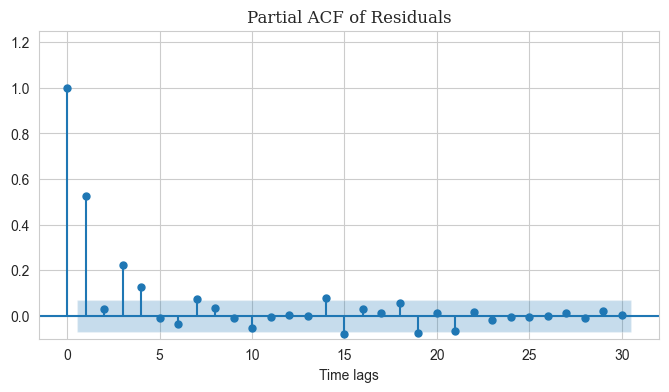

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(a**2, auto_ylims = True, lags = 30, title = 'ACF of KOSDAQ return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial ACF of Residuals', fontsize = 12, fontfamily = 'Serif')
plt.show()

기각역을 유의하게 벗어나는 지점은 $m=1$혹은 $m=4$ 지점이다. $a_t^2$에 대해 적절한 차수는 1 혹은 4가 된다

$\mathrm{ARCH}$모형의 인수로는 자산의 수익률 Series를 넣으면 된다. parameter는 다음과 같이 설정한다

- `vol` : 추정 방법을 선택한다. 기본값은 GARCH이므로, ARCH모형 추정을 위해서는 ARCH로 지정해야 한다
- `p` : 변동성에 대한 차수이다. 여기서는 4로 지정을 한다

In [11]:
arch_model = arch.arch_model(ret, vol = 'ARCH', p = 4)
result = arch_model.fit()
print(result.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 3613394925.1174083
Iteration:      2,   Func. Count:     23,   Neg. LLF: 89037.46026038281
Iteration:      3,   Func. Count:     37,   Neg. LLF: -139.46129432275745
Iteration:      4,   Func. Count:     47,   Neg. LLF: 83888795.33827144
Iteration:      5,   Func. Count:     60,   Neg. LLF: -2073.8404969838634
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2073.8404974187797
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2073.84
Distribution:                  Normal   AIC:                          -4135.68
Method:            Maximum Like

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


위 추정 결과를 해석하면 아래와 같다

$$r_t = 0.00127 + a_t$$
$$a_t = \sigma_t \epsilon_t$$
$$\sigma_t^2 = 0.00009 + 0.1768 a_{t-1}^2 + 0.1746 a_{t-2}^2 + 0.1746 a_{t-3}^2 + 0.1746 a_{t-4}^2$$

#### Exercise 1
위 경우에서 ARCH추정 모형의 변동성에 대한 차수가 1일때를 고려하여 모형을 적합화하라. 어떤 결과가 나오는가? 적합화된 결과의 계수는 적절한가? 차수를 높게 지정하였을 때 우려되는 점은 무엇인가?

**2.3 GARCH Model**

$\mathrm{ARCH}$모형은 매우 간단하였지만, 추정해야 할 계수가 늘어난다는 단점 때문에 점차 더욱 간단한 모형에 대한 요구가 늘어나기 시작하였다. Boller slev는 $\mathrm{ARCH}$모형을 일반화한 Generalized ARCH ($\mathrm{GARCH}$)모형을 제안하였는데, 변동성에 대한 ARMA모형을 추정한 것과 유사한 형태이다. 변동성을 두개의 설명변수를 통해 추정하였기에 추정해야 할 parameter가 대폭 감소하는 장점이 있다

$a_t$가 $\mathrm{GARCH}(m,s)$모형을 따를 경우 다음과 같이 나타낼 수 있다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-1}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2$$

$\eta_t = a_t^2 - \sigma_t^2$라고 가정하면 $\mathrm{GARCH}$ 모형은 다음과 같이 표현 가능하다

$$a_t^2 = \alpha_0 + \sum_{i=1}^{\max (m,s)} (\alpha_i + \beta_i) a_{i-1}^2 + \eta_t - \sum_{j=1}^s \beta_j \eta_{t-j}$$

여기서 $\eta_t$는 martingale difference Series, iid sequence로써 다음과 같은 성질을 가진다
$$E(\eta_t) = 0$$
$$\mathrm{Cov}(\eta_t, \eta_{t-j}) = 0 ~~~ \mathrm{for} ~~ j \geq 1$$

$\mathrm{ARMA}$ 모형에서와 같이 $a_t^2$의 기대값을 다음과 같이 추정 가능하다

$$E(a_t^2) = \frac{\alpha_0}{1 - \Sigma_{i=1}^{\max (m,s)}(\alpha_i + \beta_i)}$$

$\mathrm{GARCH}(1,1)$모형의 경우

$$a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2, ~~~~~ 0 \leq \alpha_1, \beta_1 \leq 1, (\alpha_1 + \beta_1) < 1$$

이다. 여기서 제약조건은 변동성이 **발산하지 않는다**로 해석할 수 있다

#### example 2

KOSDAQ 지수에 대해 2020년 1월 1일부터 2022년 12월 31일까지의 $\mathrm{GARCH}$ 모형을 추정하라. 추정된 모형을 가지고 적절한 방법으로 시각화하라

$\mathrm{GARCH}$ 모형의 차수를 정하는 것은 쉽지 않다. 다만, 대부분의 경우 order가 (1,1), (1,2), (2,1)이기 때문에, 세 모형을 모두 추정 후 비교하여 선정하는 방식을 택한다

$\mathrm{GARCH}(1,1)$인 경우

In [12]:
garch_model1 = arch.arch_model(ret, vol = 'GARCH', p = 1, q = 1)
result1 = garch_model1.fit()
print(result1.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.860446908195665e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: -2073.4749769890805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2073.474979183926
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2073.47
Distribution:                  Normal   AIC:                          -4138.95
Method:            Maximum Likelihood   BIC:                          -4120.52
                                        No. Observations:                  741
Date:                Fri, Aug 25 2023   Df Residuals:                      740
Time:     

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


$\mathrm{GARCH}(1,2)$인 경우

In [13]:
garch_model2 = arch.arch_model(ret, vol = 'GARCH', p = 1, q = 2)
result2 = garch_model2.fit()
print(result2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2104304165.7411885
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2068.5687374886747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2068.568740277803
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2068.57
Distribution:                  Normal   AIC:                          -4127.14
Method:            Maximum Likelihood   BIC:                          -4104.10
                                        No. Observations:                  741
Date:                Fri, Aug 25 2023   Df Residuals:                      740
Time:        

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


$\mathrm{GARCH}(2,1)$인 경우

In [14]:
garch_model3 = arch.arch_model(ret, vol = 'GARCH', p = 2, q = 1)
result3 = garch_model3.fit()
print(result3.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1795287482.782611
Iteration:      2,   Func. Count:     20,   Neg. LLF: -2065.3305891999944
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2065.330591079876
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2065.33
Distribution:                  Normal   AIC:                          -4120.66
Method:            Maximum Likelihood   BIC:                          -4097.62
                                        No. Observations:                  741
Date:                Fri, Aug 25 2023   Df Residuals:                      740
Time:         

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


종합적으로 고려해 봤을 때, $\mathrm{GARCH}(1,2)$인 경우가 가장 성능이 좋으므로, 최종 모델을 다음과 같이 추정한다

$$r_t = 0.00095 + a_t$$
$$a_t = \sigma_t \epsilon_t$$
$$\sigma_t^2 = 0.00003 + 0.2 a_{t-1}^2  - 0.35 σ_{t-1}^2 - 0.35 σ_{t-2}^2$$

추정된 변동성은 `conditional_volatility` 속성을 사용하여 plotting 가능하다

Text(0.5, 1.0, 'Conditional Volatility')

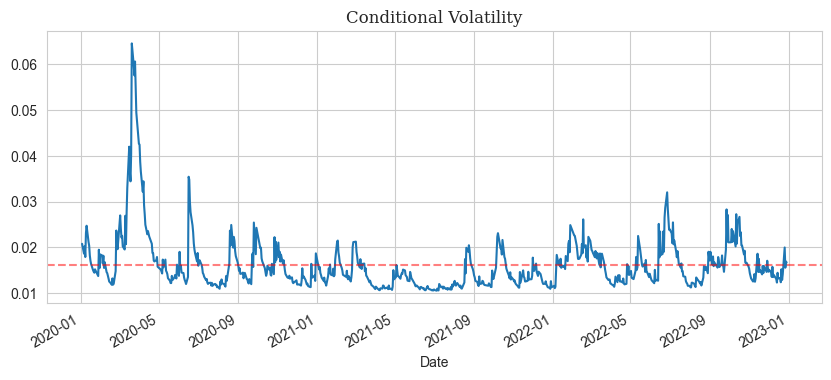

In [15]:
result2.conditional_volatility.plot(figsize = (10, 4))
plt.axhline(result2.conditional_volatility.mean(),
            color = 'red', linestyle = '--', alpha = 0.5)
plt.title('Conditional Volatility', fontfamily = 'Serif', fontsize = 12)

#### 3. Stochastic Volatility Models

Financial Time Series의 변동성을 설명하기 위한 대안적 접근법은 conditional variance equation인 $a_t$에 다른 접근법을 도입하는 것이다. 그 결과로 확률적 변동성 모다(stochastic volatility model)이 제작되었다. $\mathrm{EGARCH}$ 모형과 마찬가지로 조건부 분산이 양수라는 것을 보장하기 위해 SV 모형 또한 $\sigma_t^2$ 대신 $\ln \sigma_t^2$를 사용한다

**3.1 Stochastic volatility model**

1987년 Hull과 White는 Black과 Scholes가 제안한 모형을 일반화하여 옵션 가격 분석에 이용하였는데, 이 모형이 Stchastic volatility 모형의 표준적인 형태로 사용되고 있다. stochastic volatility model은 다음과 같이 정의된다
$$a_t = \sigma_t \epsilon_t, ~~~~~ (1 - \alpha_1B - \cdots - \alpha_m B^m) \ln(\sigma_t^2) = \alpha_0 + v_t$$

여기서 $\epsilon_t$는 iid이고 평균이 0, 분산이 1인 정규분포를 따르며, $v_t$는 iid이고 평균이 0, 분산이 $\sigma_v^2$인 정규분포를 따른다. $\{\epsilon_t\}, \{v_t\}$는 모두 독립이고, $\alpha_0$은 상수이다. SV 모델을 추정하려면 Kalman Filtering 또는 Monte Carlo Method를 통한 quasi-likelihood methods가 필요하다

Jacquier, Polson, Rossi는 $m=1$일때 SV model의 특성을 정리하였다

$$\ln (\sigma_t^2) \sim N(\frac{\alpha_0}{1-\alpha_1}, \frac{\sigma_v^2}{1 - \alpha_1^2}) \equiv N(\mu_h, \sigma_h^2)$$

여기서
$$E(a_t^2) = \exp (\mu_h + \sigma_h^2/2)$$
$$E(a_t^4) = 3 \exp (2 \mu_h^2 + 2 \sigma_h^2)$$
$$\mathrm{corr} = \frac{\exp(\sigma_h^2\alpha_1^i) - 1}{3 \exp(\sigma_h^2 - 1)}$$

제한적인 경험에 따르면 SV 모형은 종종 모형 적합성 개선에는 기여했으나, 표본 외 변동성 예측에 대한 성능은 상반된 평가를 받았다. 예측 편향이 증가하고 분산이 줄어든 결과로 보인다

**3.2 Long memory Stochastic volatility model**

최근에는 Fractional difference의 아이디어를 이용하여 장기 기억의 변동성을 포함할 수 있도록 SV model을 일반화하는 모형이 있다. 시장의 장기 기억을 가지고 있는 단순한 Long Memory Stochastic Volatility (LMSV) model은 다음과 같이 쓸 수 있다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t = \sigma \exp(u_t/2), ~~~~~ (1-B)^d u_t = \eta_t$$

여기서 $\sigma > 0 ,\epsilon_t$는 iid이고 $N(0,1)$이다. $\eta_t$는 iid이며 $N(0,\sigma_\eta^2)$이고 $\epsilon_t$에 대해 독립적이다. 적분차수 d는 0와 0.5사이에 있다고 가정한다. 적분차수가 1보다 작으므로 ACF는 1차 적분계열에 비해 좀 더 느리게 낮아지고, time lag는 늘어날 것이다

$$\begin{matrix}
\ln(a_t^2) &=& \ln(\sigma^2) + u_t + \ln(\epsilon_t^2) \\
       &=& [\ln(\sigma^2) + E(\ln \epsilon_t^2)] + u_t + [\ln(\epsilon_t^2) - E(\ln \epsilon_t^2)] \\
       &\equiv& \mu+u_t + e_t
\end{matrix}$$

따라서, $\ln(a_t^2)$는 Gaussian long-memory signal에 non gaussian white noise이다. Long memory Stochastic volatility model의 추정은 매우 복잡하다. 여기서 fractional difference parameter $d$는 quasi maximum likelihood method이나 regression method를 사용해서 추정한다

#### example 3
아래의 함수를 사용하여 KOSDAQ 주가지수의 2020년 1월 1일부터 2022년 12월 31일까지의 일별 데이터를 가지고 확률적 변동성 모형을 추정해 보라. 그리고 example 2에서 추정한 $\mathrm{GARCH}$모형의 변동성과 비교하라. 어떤 차이가 있는가?

In [16]:
import os
import arviz as az
import pymc as pm
import numpy as np

rng = np.random.default_rng(42)

def StochasticVolatilityModel(data):
    with pm.Model(coords = {"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk("volatility", sigma = step_size, dims = "time")
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT("returns", nu = nu, lam = np.exp(-2 * volatility), observed = data, dims = "time")
    return model

In [17]:
svmodel = StochasticVolatilityModel(ret)

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/pymc/distributions/timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(


In [19]:
with svmodel:
    idata = pm.sample_prior_predictive(500, random_seed = rng)

prior_predictive = az.extract(idata, group = "prior_predictive")

Sampling: [nu, returns, step_size, volatility]


pymc library의 `sample_prior_predictive` 함수를 사용하여 prior distribution을 추정한다

In [20]:
prior_predictive

<xarray.Dataset>
Dimensions:  (time: 741, sample: 500)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-03 2020-01-06 ... 2022-12-29
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    returns  (time, sample) float64 3.843e+06 1.279e-62 ... -0.008383 -1.906e+25
Attributes:
    created_at:                 2023-08-24T17:35:37.222102
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  5.7.2

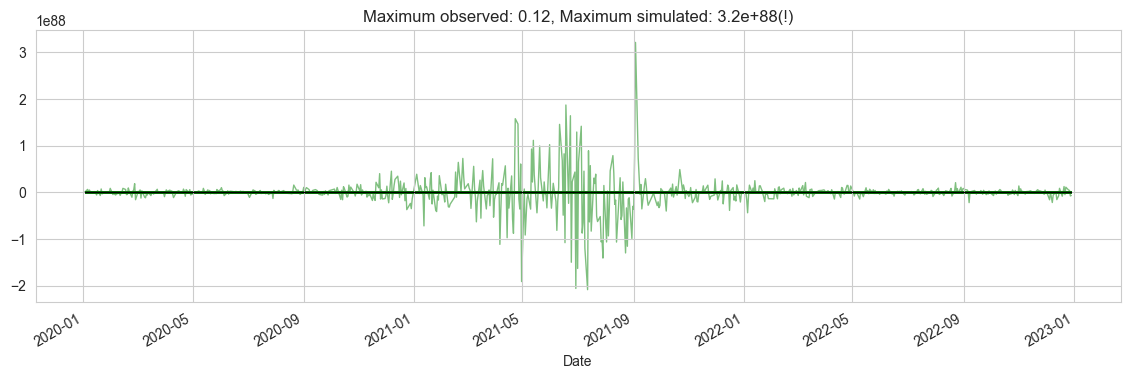

In [21]:
fig, ax = plt.subplots(figsize = (14, 4))
ret.plot(ax = ax, lw = 1, color = "black")
res = pd.DataFrame(prior_predictive["returns"][:, 0::10].values)
res.index = ret.index
ax.plot(res, "g", alpha = 0.5, lw = 1, zorder = -10)

max_observed, max_simulated = np.max(np.abs(ret)), np.max(np.abs(res))
ax.set_title(f"Maximum observed: {max_observed:.2g}, Maximum simulated: {max_simulated:.2g}(!)");

경험적 시계열 이외에 montecarlo simulation을 통한 prior의 return을 얻어낼 수 있다

In [22]:
with svmodel :
    idata.extend(pm.sample(random_seed = rng))

posterior = az.extract(idata)
posterior["exp_volatility"] = np.exp(posterior["volatility"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [step_size, volatility, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [23]:
with svmodel:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed = rng))

posterior_predictive = az.extract(idata, group = "posterior_predictive")

Sampling: [returns]


위와 같이 베이즈 정리를 이용해 prior 사건으로 posterior 사건을 구한다

array([[<Axes: title={'center': 'step_size'}>,
        <Axes: title={'center': 'step_size'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>]],
      dtype=object)

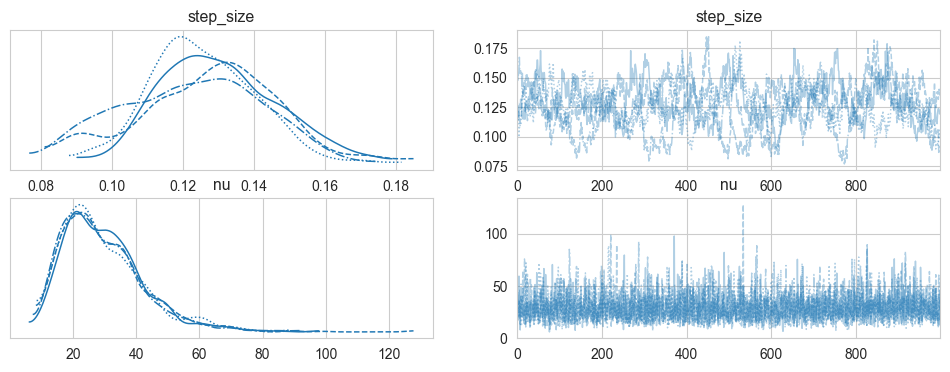

In [24]:
az.plot_trace(idata, var_names = ["step_size", "nu"])

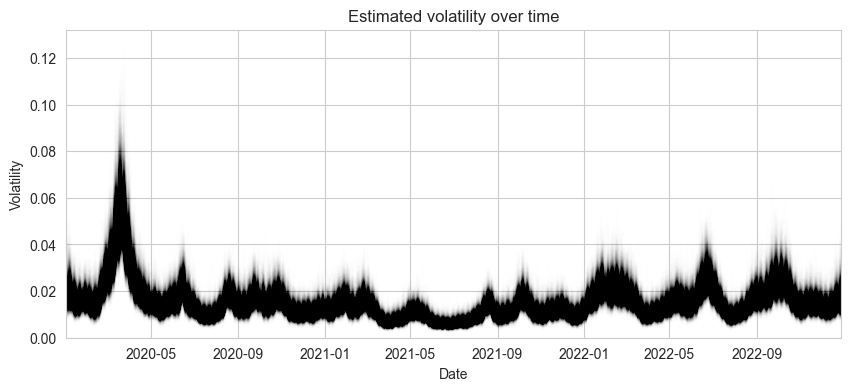

In [25]:
fig, ax = plt.subplots(figsize = (10, 4))

y_vals = posterior["exp_volatility"]
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha = 0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom = 0)
ax.set(title = "Estimated volatility over time", xlabel = "Date", ylabel = "Volatility");

Montecarlo simulation을 통해 posterior 사건들의 변동성을 구할 수 있다

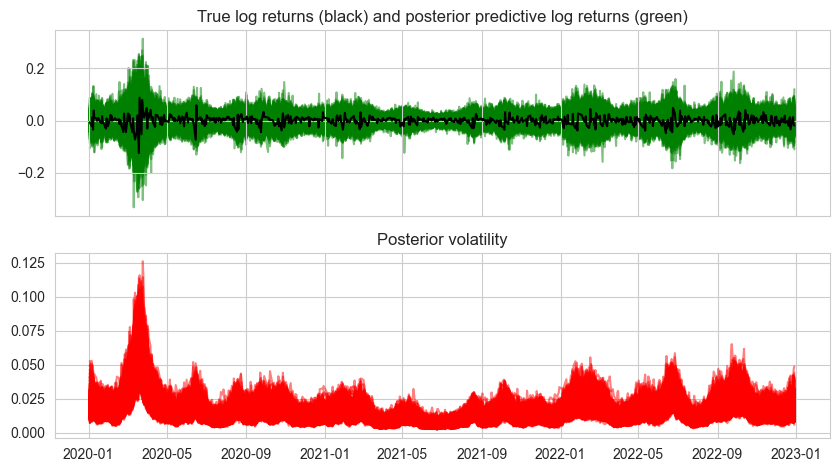

In [26]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 6), sharex = True)
ret.plot(ax=axes[0], color="black")

axes[1].plot(pd.DataFrame(posterior["exp_volatility"], index = ret.index), "r", alpha = 0.5)
axes[0].plot(pd.DataFrame(posterior_predictive["returns"], index = ret.index), "g", alpha = 0.5, zorder = -10)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");

추정된 montecarlo simulation의 변동성은 위와 같다. SV model의 추정된 변동성을 $\mathrm{GARCH}(1,2)$로 추정한 결과와 비교해 보자

Text(0.5, 1.0, 'Conditional Volatility')

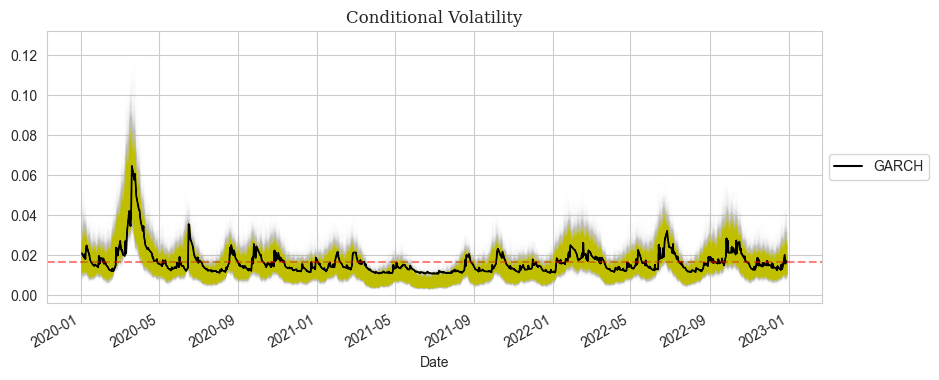

In [27]:
result2.conditional_volatility.plot(figsize = (10, 4), label = 'GARCH', color = 'k')
plt.axhline(result2.conditional_volatility.mean(),
            color = 'red', linestyle = '--', alpha = 0.5)
plt.plot(x_vals, y_vals, "y", alpha = 0.002)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Conditional Volatility', fontfamily = 'Serif', fontsize = 12)

SV model로 추정한 결과에 비해 $\mathrm{GARCH}(1,2)$로 추정한 결과가 편향이 있는 결과를 보인다. 반면에 SV model은 경험적 $\mathrm{GARCH}(1,2)$ 모형에 비해서 변동성이 낮은 구간에서는 과소 추정을, 높은 구간에서는 과대 추정을 하는 것으로 보인다. 이는 monte carlo simulation에서 상승과 하강 확률을 동일하게 정규분포로 추정하였기 때문에 생긴 차이인 것으로 보인다

#### Exercise 3

KOSPI에 상장된 회사 중 하나를 선정하여 2020년 1월 1일부터 2022년 12월 31일까지의 $\mathrm{GARCH}$모형과 $\mathrm{SV~model}$을 추정하라. 그리고 그 둘의 결과를 비교해 보라. 최적의 $\mathrm{GARCH}$모형의 order는 무엇인가? $\mathrm{SV~model}$과 어떤 차이를 보이는가?

#### 4. Aiternative Approaches

**4.1 Corwin and Schultz**

Corwin, Schultz는 매매 호가 스프레드를 가격의 퍼센티지로 다음과 같이 계산할 수 있다는 것을 보였다. 매매 호가 스프레드는 장중 High, Low 가격에 대한 series로 대체될 수 있다

$$S_t = \frac{2(e^{\alpha_t}-1)}{1+e^{\alpha_t}}$$

여기서

$$\alpha_t = \frac{\sqrt{2\beta_t} - \sqrt{\beta_t}}{3 - 2\sqrt{2}} - \sqrt{\frac{\gamma_t}{3-2\sqrt{2}}}$$
$$\beta_t = E \Big[\sum_{j=0}^1 \Big[\log \Big(\frac{H_{t-j}}{L_{t-j}} \Big) \Big]^2\Big]$$
$$\gamma_t = \Big[\log \Big(\frac{H_{t-1, t}}{L_{t-1, t}}\Big) \Big]^2$$

$H_{t-1,t}$는 두 기간에 걸친 고가이고, $L_{t-1,t}$는 두 기간에 걸친 저가이다. Corwin-Schultz의 식에서는 변동성이 보이지 않는데, 이는 고가/저가 추정량으로 대체되었기 때문이다. 이 모델로써 벡커-파킨슨 변동성을 유도할 수 있다

**4.2 High-Low Volatility Estimator**

Parkinson(1980)은 기하 브라운 운동을 따르는 연속적으로 관측되는 가격에 대해 다음을 유도했다

$$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_1\sigma_{HL}^2$$
$$E\Big[ \frac{1}{T} \sum_{t=1}^T \Big( \log\Big[\frac{H_t}{L_t}\Big]\Big)\Big] = k_2\sigma_{HL}$$

여기서 $k_1 = 4\log(2), k_1 = \sqrt{\frac{8}{\pi}}$, $H_t$는 바 t에 대한 고가이고, $L_t$는 바 t에 대한 저가이다. 그러면 변동성 특성 $\sigma_{HL}$은 관측된 고가-저가에 기초해 안정적으로 계산 가능하다

#### example 4

다음의 함수들을 이용하여 Becker Parkinson range volatility를 추정하라. range volatility 추정을 위해 Corwin & Schultz의 스프레드를 사용할 수 있다. 데이터는 2020년 1월 1일부터 2022년 12월 31일까지의 Apple 가격 데이터를 이용하라. Becker Parkinson volatility는 $\mathrm{GARCH}$모형과 비교하였을때 어떠한 특징을 보이는가?

In [28]:
def getBeta(series : pd.DataFrame, sl : int) :
    h1 = series[['High','Low']].values
    h1 = np.log(h1[:,0]/h1[:,1])**2
    h1 = pd.Series(h1, index = series.index)
    beta = h1.rolling(window = 2).sum()
    beta = beta.rolling(window = sl).mean()
    beta = beta.replace([np.inf, -np.inf], np.nan)
    return beta.dropna()

def getGamma(series : pd.DataFrame) :
    h2 = series['High'].rolling(window=2).max()
    l2 = series['Low'].rolling(window=2).min()
    gamma = np.log(h2.values/l2.values)**2
    gamma = pd.Series(gamma, index = h2.index)
    gamma = gamma.replace([np.inf, -np.inf], np.nan)
    return gamma.dropna()

def getAlpha(beta, gamma) :
    alpha = ((np.sqrt(2 * beta) - np.sqrt(beta)) /(3 - (2 * np.sqrt(2)))) - np.sqrt(gamma / (3 - (2 * np.sqrt(2))))
    alpha[alpha<0] = 0
    return alpha.dropna()

def corwinSchultz(series, sl : int = 1) :
    beta = getBeta(series, sl)
    gamma = getGamma(series)
    alpha = getAlpha(beta, gamma)
    spread = 2 * np.exp(alpha - 1)/(1 + np.exp(alpha))
    startTime = pd.Series(series.index[0 : spread.shape[0]], index = spread.index)
    spread = pd.concat([spread,startTime], axis = 1)
    spread.columns = ['Spread', 'Start_time']
    return spread

def getSigma(beta, gamma) :
    k2 = (8/np.pi)**.5
    den = 3-2*2**.5
    sigma = (2**-.5-1)*beta**.5/(k2*den)
    sigma += (gamma/(k2**2*den))**.5
    sigma[sigma<0] = 0
    return sigma

yfinance를 이용해 Apple의 일별 주가 데이터를 가져오도록 한다

In [29]:
import yfinance as yf

start_date = '2020-01-01'
end_date = '2023-08-01'

apple = yf.download('AAPL', start = start_date, end = end_date)
apple

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.249031,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.536896,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.114883,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.771019,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.941628,132079200
...,...,...,...,...,...,...
2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200
2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900
2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200


$\beta$는 주식 가격 변동성과 거래량 사이의 관계를 나타내는 지표이다. 거래량과 가격 변동성의 상관관계를 나타내므로, 상대 강도를 결정하는 데에 영향을 미치게 된다

In [30]:
getBeta(apple, 1)

Date
2020-01-03    0.000517
2020-01-06    0.000779
2020-01-07    0.000723
2020-01-08    0.000716
2020-01-09    0.000774
                ...   
2023-07-25    0.000250
2023-07-26    0.000204
2023-07-27    0.000712
2023-07-28    0.000732
2023-07-31    0.000202
Length: 899, dtype: float64

$\gamma$는 주식의 상대 강도(Spread)를 계산하는 데에 사용되는 또 다른 지표이다. 특정 윈도우 간의 고가와 저가 의 로그 차분값의 제곱으로 계산된다

In [31]:
getGamma(apple)

Date
2020-01-03    0.000330
2020-01-06    0.000697
2020-01-07    0.000754
2020-01-08    0.000586
2020-01-09    0.001909
                ...   
2023-07-25    0.000189
2023-07-26    0.000196
2023-07-27    0.000569
2023-07-28    0.000569
2023-07-31    0.000162
Length: 899, dtype: float64

$\alpha$는 주식의 가격 변동성과 거래량 사이의 관계를 조합하여 주식의 상대적인 강도를 나타내는 지표이다. $\alpha$가 음수인 경우, 주식의 가격 변동과 거래량 사이의 관계에서 상대적으로 약한 상태를 나타낸다

<Axes: title={'center': 'Corwin-Schultz bid-ask spread'}, xlabel='Date'>

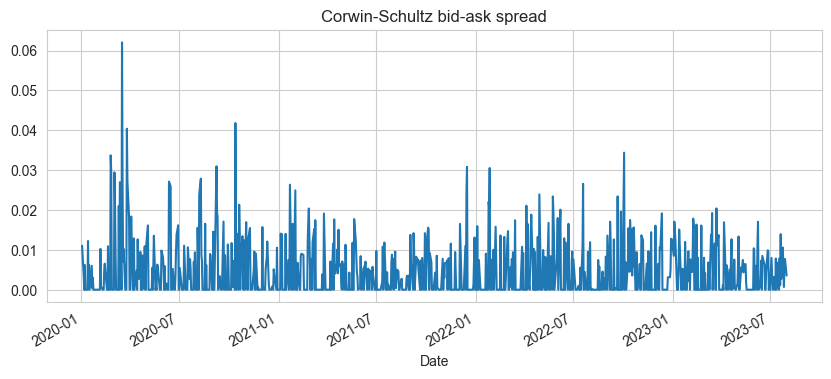

In [32]:
getAlpha(getBeta(apple, 1), getGamma(apple)).plot(figsize = (10,4), title = 'Corwin-Schultz bid-ask spread')

`corwinSchultz()` 함수는 spread의 상대 강도와 start time의 정보를 담는 pandas DataFrame 형태의 데이터를 출력한다

In [33]:
corwinSchultz(apple, sl = 1)

,Spread,Start_time
Date,,
2020-01-03,0.369908,2020-01-02
2020-01-06,0.368550,2020-01-03
2020-01-07,0.367879,2020-01-06
2020-01-08,0.369018,2020-01-07
2020-01-09,0.367879,2020-01-08
...,...,...
2023-07-25,0.368805,2023-07-24
2023-07-26,0.368003,2023-07-25
2023-07-27,0.369130,2023-07-26


`getSigma`함수를 사용하여 고가/저가 추정량으로 대체된 Becker Parkinson 변동성을 구할 수 있다

<Axes: title={'center': 'Becker Parkinson Volatility Estimator'}, xlabel='Date'>

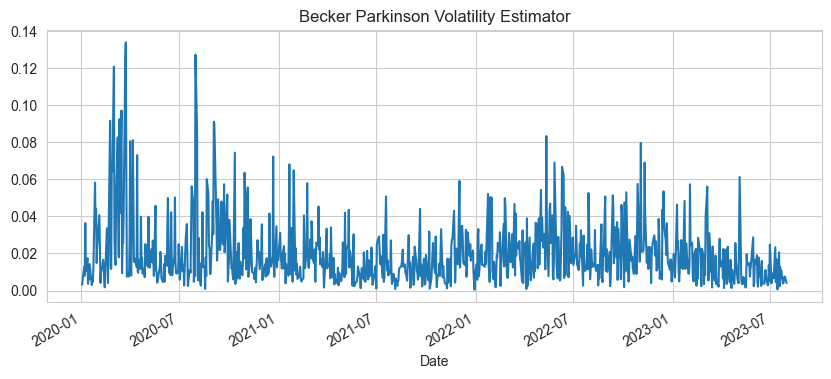

In [43]:
getSigma(getBeta(apple, 1), getGamma(apple)).plot(figsize = (10,4), title = 'Becker Parkinson Volatility Estimator')

$\mathrm{GARCH}$모형에서 추정된 변동성과 비교를 위해 $\mathrm{GARCH}$모형을 추정한다

In [35]:
ret_apple = np.log(apple.Close / apple.Close.shift(1)).dropna()
ret_apple

Date
2020-01-03   -0.009770
2020-01-06    0.007937
2020-01-07   -0.004714
2020-01-08    0.015958
2020-01-09    0.021018
                ...   
2023-07-25    0.004503
2023-07-26    0.004535
2023-07-27   -0.006603
2023-07-28    0.013418
2023-07-31    0.003161
Name: Close, Length: 899, dtype: float64

In [36]:
garch = arch.arch_model(ret_apple, vol = 'GARCH', p = 1, q = 1)
res_apple = garch.fit()
print(res_apple.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6741586773.594191
Iteration:      2,   Func. Count:     18,   Neg. LLF: -128.94846847063783
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1583.9855567433456
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1872.9927445092778
Iteration:      5,   Func. Count:     44,   Neg. LLF: -2167.427488791145
Iteration:      6,   Func. Count:     52,   Neg. LLF: -2250.639231762237
Iteration:      7,   Func. Count:     59,   Neg. LLF: -2263.191577719747
Iteration:      8,   Func. Count:     65,   Neg. LLF: -2267.377296624354
Iteration:      9,   Func. Count:     70,   Neg. LLF: -2267.377282220037
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2267.3772966243096
            Iterations: 9
            Function evaluations: 80
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:    

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [37]:
garch1 = arch.arch_model(ret_apple, vol = 'GARCH', p = 1, q = 2)
res_apple1 = garch1.fit()
print(res_apple1.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 549106579.4326127
Iteration:      2,   Func. Count:     19,   Neg. LLF: -2262.621492252415
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2262.6214945588727
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2262.62
Distribution:                  Normal   AIC:                          -4515.24
Method:            Maximum Likelihood   BIC:                          -4491.24
                                        No. Observations:                  899
Date:                Fri, Aug 25 2023   Df Residuals:                      898
Time:         

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [38]:
garch2 = arch.arch_model(ret_apple, vol = 'GARCH', p = 2, q = 1)
res_apple2 = garch2.fit()
print(res_apple2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5254402166.127924
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7143.957810756512
Iteration:      3,   Func. Count:     30,   Neg. LLF: -2267.381402915408
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2267.3814036163194
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2267.38
Distribution:                  Normal   AIC:                          -4524.76
Method:            Maximum Likelihood   BIC:                          -4500.76
                                        No. Observations:                  899
Date:                

/Users/tommylee/Desktop/Pycharm/QUANTIFI/venv/lib/python3.9/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004805. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


$\mathrm{GARCH}(1,2)$모형이 가장 적합하다고 판단하여 이 모형의 추정량을 사용한다

Text(0.5, 1.0, 'GARCH vs Becker Parkinson Range Volatility')

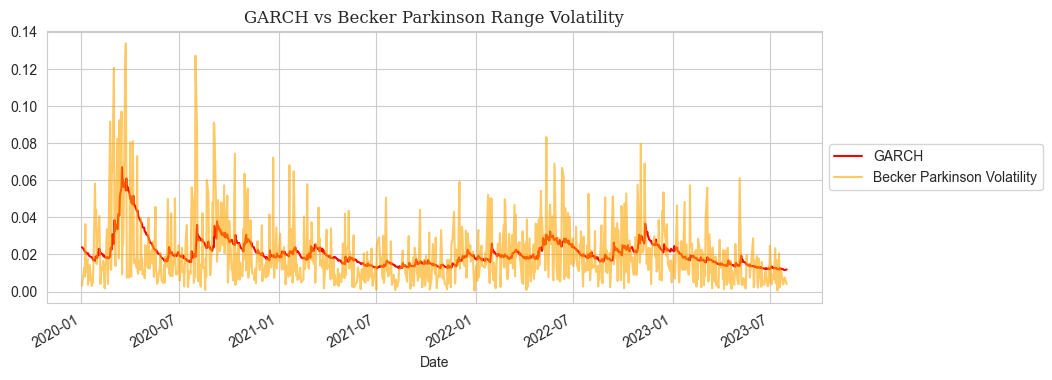

In [42]:
res_apple1.conditional_volatility.plot(figsize = (10, 4), label = 'GARCH', color = 'r')
getSigma(getBeta(apple, 1), getGamma(apple)).plot(figsize = (10,4), label = 'Becker Parkinson Volatility', alpha = 0.6, color = 'orange')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('GARCH vs Becker Parkinson Range Volatility', fontfamily = 'Serif', fontsize = 12)

$\mathrm{GARCH}$모형을 이용해 추정한 변동성이 Becker Parkinson 변동성 추정량의 하나의 상태 공간(State Space)처럼 작용한다

#### Exercise 4

Exercise 3에서 사용한 가격 Series를 사용하여 다음 물음에 답하라
1. Corwin-Schultz spread를 추정하라

2. 추정된 spread를 활용하여 Becker Parkinson Range Volatility를 추정하라

3. SV model로 추정한 변동성과 어떤 차이를 보이는가?

4. $\mathrm{GARCH}$모형으로 추정한 변동성과는 어떤 차이를 보이는가?

5. 위험 회피 거래가 목적이라면 세 개의 변동성 추정량 중 어떤 추정량을 사용해야 하는가?